### CH8. 차원 축소

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

* 투영 방법 (3D 데이터셋)

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

#### SVD 분해를 사용한 PCA

$X = U \sum V^T$ 에서 $V$가 주성분

* (m, m) (m, n) (n, n)

m: 샘플 개수, n: 특성 개수

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

* 사이킷런을 사용한 PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

* 데이터셋을 조금 다르게해서 PCA를 실행하면 결과가 달라짐. (일부 축이 반대로 바뀜)
* 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것 외에는 SVD 방식을 사용한 것과 동일.

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

* 평면(PCA 2D 부분공간)에 투영된 3D 포인트 복원

In [12]:
X3D_inv = pca.inverse_transform(X2D)

* 투영 단계에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 원본 3D 포인트와 완전히 똑같지는 않음

In [13]:
np.allclose(X3D_inv, X)

False

* 재구성 오차 계산

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

* SVD 방식의 역변환

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

* 사이킷런의 PCA 클래스: 자동으로 평균을 뺐던 것을 복원, 두 방식의 재구성 오차가 동일하지 않음. 평균을 빼면 동일한 재구성.

In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

* PCA 객체를 사용하여 계산된 주성분을 참조할 수 있음

In [18]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

* SVD 방법으로 계산된 처음 두 개의 주성분과 비교.

In [19]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

==> 축이 뒤집힘

* 설명된 분산 비율

In [20]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

==> 첫 번째 차원이 84.2%의 분산을 포함, 두 번째는 14.6%의 분산을 설명.

* 2D로 투영 --> 분산의 1.1% 손실

In [21]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

* SVD 방식에서 설명된 분산의 비율을 계산하는 방법 (s = diag(S))

In [22]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

* 3D 화살표를 그래기 위한 유틸리티 클래스(http://stackoverflow.com/questions/11140163)

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

* x와 y의 함수로 평면을 표현

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

* 3D 데이터셋, 평면 그리고 이 평면으로의 투영

그림 저장 dataset_3d_plot


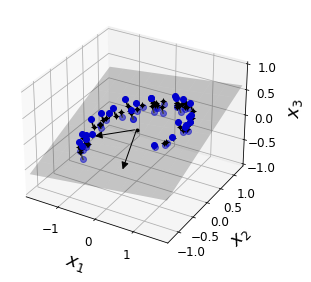

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: 맷플롯립 3.0.0 버전은 버그가 있기 때문에
# 3D 그래프를 잘 출력하지 못합니다.
# https://github.com/matplotlib/matplotlib/issues/12239 를 참조하세요.
# 따라서 최신 버전으로 업그레이드해야 합니다.
# 만약 업그레이드할 수 없다면 3D 그래프를 그리기 전에 다음 코드를 실행하세요:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

그림 저장 dataset_2d_plot


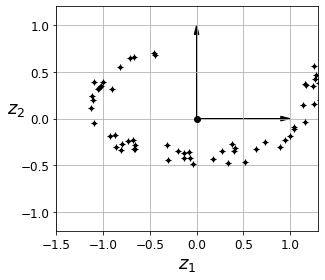

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

#### 매니폴드 학습
1. 스위스 롤:

In [27]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

그림 저장 swiss_roll_plot


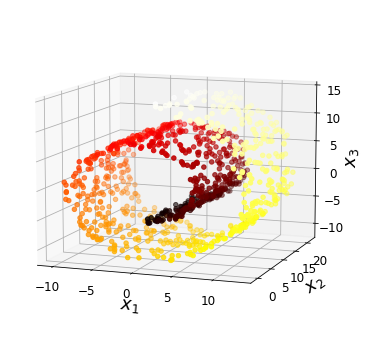

In [28]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

그림 저장 squished_swiss_roll_plot


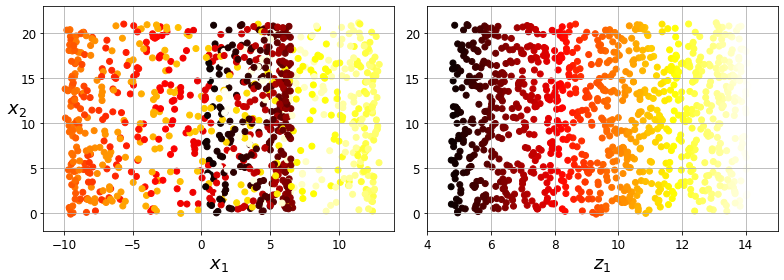

In [29]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

그림 저장 manifold_decision_boundary_plot1


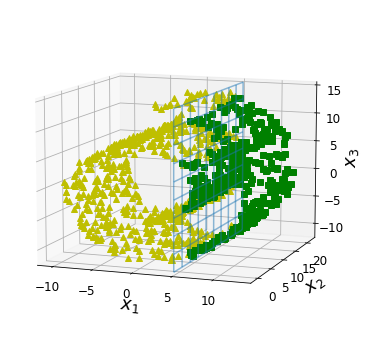

그림 저장 manifold_decision_boundary_plot2


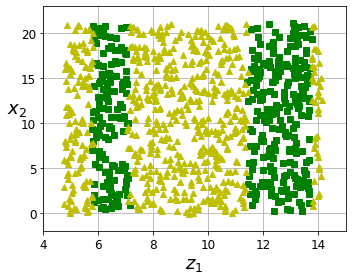

그림 저장 manifold_decision_boundary_plot3


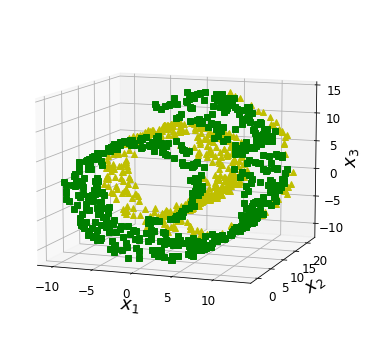

그림 저장 manifold_decision_boundary_plot4


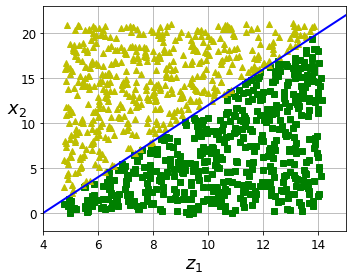

In [30]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

#### PCA

그림 저장 pca_best_projection_plot


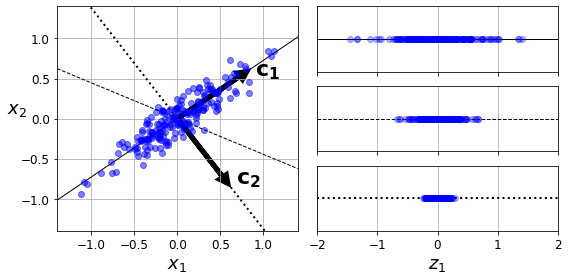

In [31]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

#### MNIST 압축

In [32]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [33]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [35]:
d

154

그림 저장 explained_variance_plot


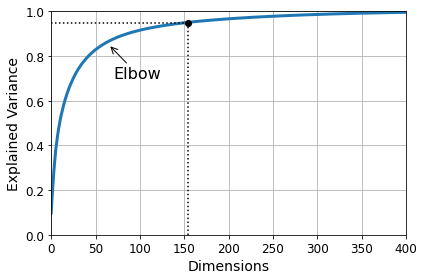

In [36]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [37]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [38]:
pca.n_components_

154

In [39]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295705

In [40]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [41]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장 mnist_compression_plot


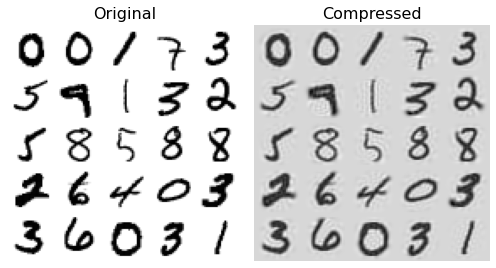

In [42]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [43]:
X_reduced_pca = X_reduced

#### 점진적 PCA

In [44]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # 책에는 없음
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [45]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

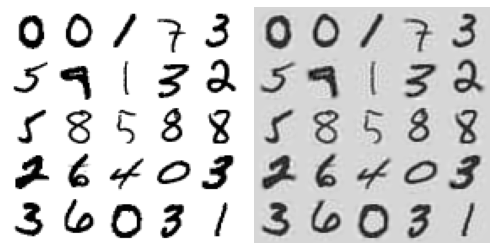

In [46]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [47]:
X_reduced_inc_pca = X_reduced

* 일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과 비교. 평균이 같은가?

In [48]:
np.allclose(pca.mean_, inc_pca.mean_)

True

* 결과는 완전히 동일하지 않음. 점진적 PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지는 않다!

In [49]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

#### `memmap()` 사용하기

In [50]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

* 데이터가 디스크에 저장되었는지 확인하기 위해 `memmap()` 객체를 삭제.

In [51]:
del X_mm

* 다른 프로그램에서 데이터를 로드하여 훈련에 사용

In [52]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [53]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

#### 시간 복잡도

* 주성분 개수를 바꾸어가며 점진적 PCA와 랜덤 PCA에 비교해 일반 PCA 시간 측정

In [54]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} 초".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 98.5 초
    IncrementalPCA: 119.2 초
    PCA: 9.4 초
n_components = 10
    PCA: 78.5 초
    IncrementalPCA: 120.2 초
    PCA: 11.5 초
n_components = 154
    PCA: 73.7 초
    IncrementalPCA: 179.9 초
    PCA: 44.8 초


* 데이터셋의 크기(샘플의 수)를 바꾸어가며 일반 PCA와 랜덤 PCA를 비교

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

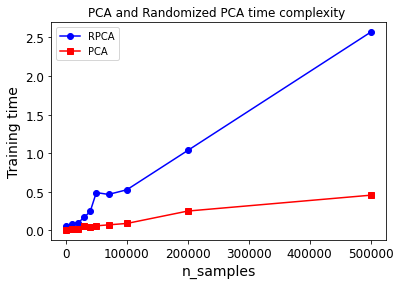

In [55]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

* 특성의 개수를 달리하면서 2,000 샘플이 있는 데이터셋에서 성능을 비교

In [56]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

#### 커널 PCA

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

In [ ]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

In [ ]:
print(grid_search.best_params_)

In [ ]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

#### LLE

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

#### MDS, Isomap, t-SNE

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

* 다시 꼭 복습하기!